# Prediksi Nilai Tukar Mata Uang Dollar (USD) Terhadap Rupiah (IDR)

data [Nilai Tukar Rupiah](https://satudata.kemendag.go.id/data-informasi/perdagangan-dalam-negeri/nilai-tukar)

## Langkah 1: Import Dataset

In [5]:
library(readxl) #membaca data excel
library(tseries) #package timeseries
library(lmtest) #untuk coeftest
library(forecast) #untuk accuracy dan prediksi

data <- read_excel("rp_usd.xlsx")
data$Rupiah <- as.numeric(gsub(",", "", data$Rupiah))

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric




## Langkah 2 : Identifikasi Model

In [6]:
data <- ts(data, frequency = 12, start = c(2015, 1))
data

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
2015,12625,12863,13084,12937,13211,13332,13481,14027,14657,13639,13840,13795
2016,13846,13395,13276,13204,13615,13180,13094,13300,12998,13051,13563,13436
2017,13343,13347,13321,13327,13321,13319,13323,13351,13492,13572,13514,13548
2018,13413,13707,13756,13877,13951,14404,14413,14711,14929,15227,14339,14481
2019,14072,14062,14244,14215,14385,14141,14026,14237,14174,14008,14102,13901
2020,13662,14234,16367,15157,14733,14302,14653,14554,14918,14690,14128,14105
2021,14084,14229,14572,14468,14310,14496,14491,14374,14307,14199,14340,14269
2022,14381,14371,14349,14418,14544,14848,14958,14875,15247,15542,15737,15731


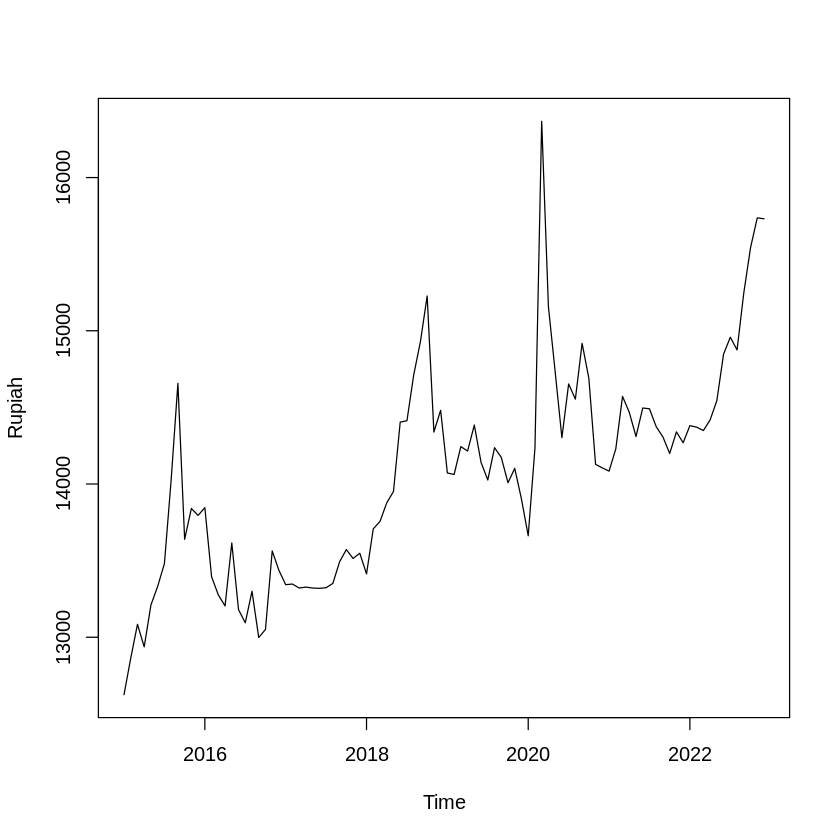

In [7]:
plot.ts(data) #melihat plot dari data

## Langkah 3: Cek Stasioner Mean dan Varians


### Cek stasioner data

In [8]:
adf_result <- adf.test(data)
adf_result


	Augmented Dickey-Fuller Test

data:  data
Dickey-Fuller = -2.8744, Lag order = 4, p-value = 0.2151
alternative hypothesis: stationary


Karena nilai p-value $>\alpha$ = 0.05 maka Tolak H0 atau data belum stasioner


	Augmented Dickey-Fuller Test

data:  data
Dickey-Fuller = -2.8744, Lag order = 4, p-value = 0.2151
alternative hypothesis: stationary


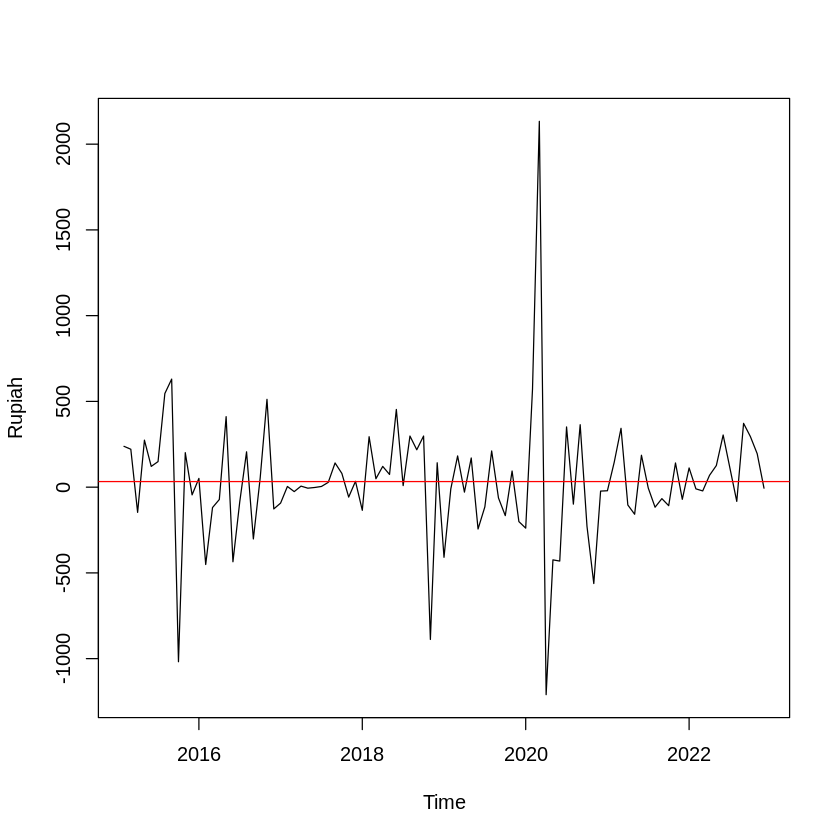

In [9]:
#Mengatasi data tidak stasioner pada rataan
data1<- diff(data)

# plot
plot(data1)
ratadiff = mean(data1)
abline(h=ratadiff, col='red')

# adf test
adf.test(data)

Nilai p-value masih $>\alpha$ = 0.05 maka Tolak H0 atau data belum stasioner, maka dilakuakan 2 kali differencing

Warning message in adf.test(data2):
“p-value smaller than printed p-value”



	Augmented Dickey-Fuller Test

data:  data2
Dickey-Fuller = -4.825, Lag order = 4, p-value = 0.01
alternative hypothesis: stationary


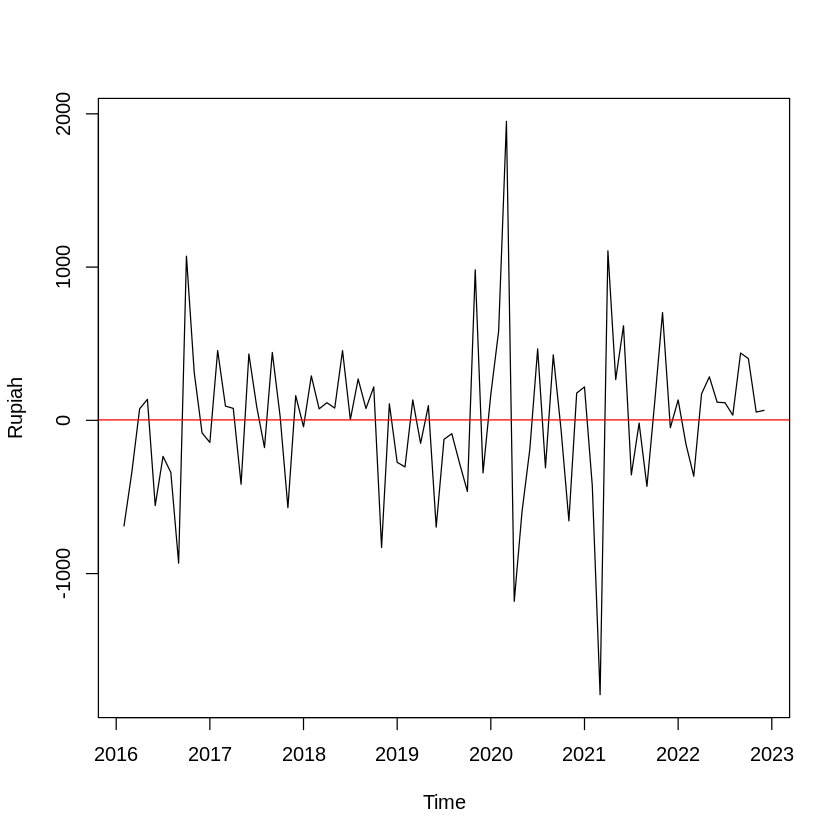

In [11]:
data2 = diff(data1, lag=12)
plot(data2)
ratadiff = mean(data2)
abline(h=ratadiff, col='red')
adf.test(data2)

Karena nilai p-value $<\alpha$ = 0.05 maka terima H0 atau data sudah stasioner

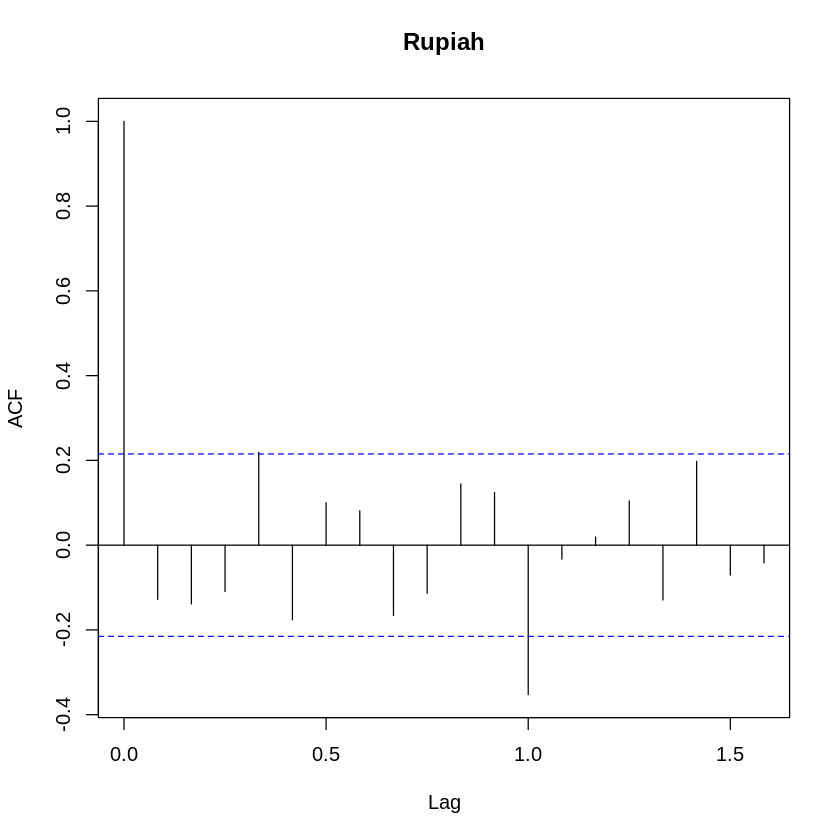

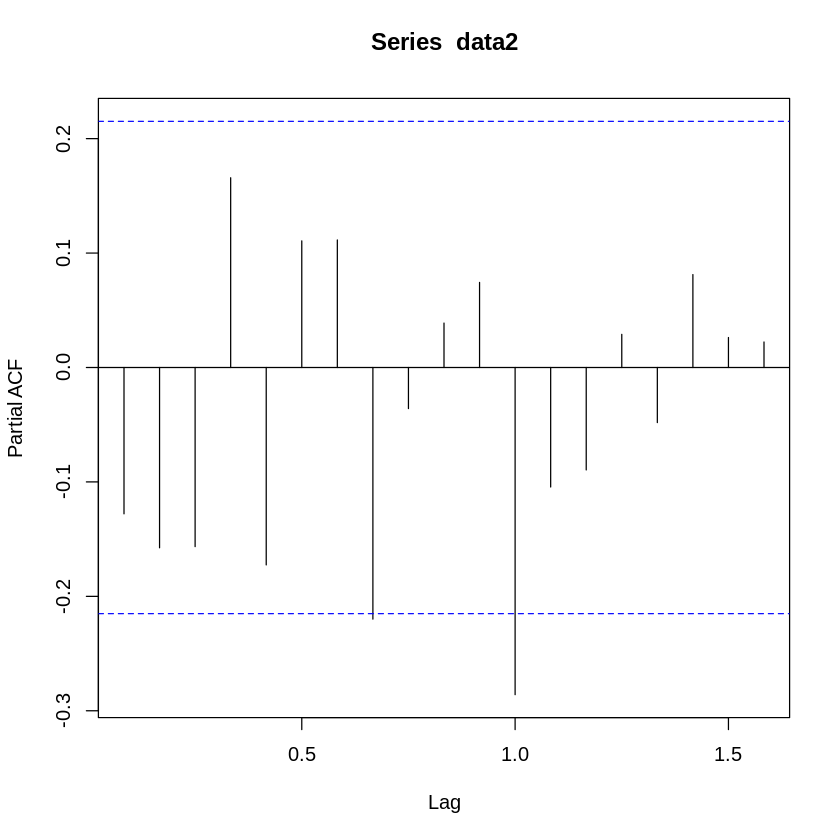

In [12]:
acf(data2)
pacf(data2)

## SARIMA

### Langkah 4 : Menentukan Orde SARIMA (p,d,q) x (P,D,Q)s

In [13]:
auto.arima(data2)

Series: data2 
ARIMA(0,0,1)(2,0,0)[12] with zero mean 

Coefficients:
          ma1     sar1     sar2
      -0.2516  -0.5951  -0.4570
s.e.   0.1338   0.1101   0.1112

sigma^2 = 174311:  log likelihood = -621.03
AIC=1250.06   AICc=1250.57   BIC=1259.74

In [14]:
model1 = arima(data2, orde=c(0,0,1), seasonal=list(order=c(2,0,0),period=12), method="ML")

summary(model1)


Call:
arima(x = data2, order = c(0, 0, 1), seasonal = list(order = c(2, 0, 0), period = 12), 
    method = "ML")

Coefficients:
          ma1     sar1     sar2  intercept
      -0.2541  -0.5963  -0.4581     5.5451
s.e.   0.1342   0.1101   0.1111    18.4971

sigma^2 estimated as 167755:  log likelihood = -620.99,  aic = 1251.97

Training set error measures:
                    ME     RMSE      MAE      MPE    MAPE      MASE       ACF1
Training set -14.53681 409.5794 278.7101 116.4263 143.591 0.5212861 0.04356724

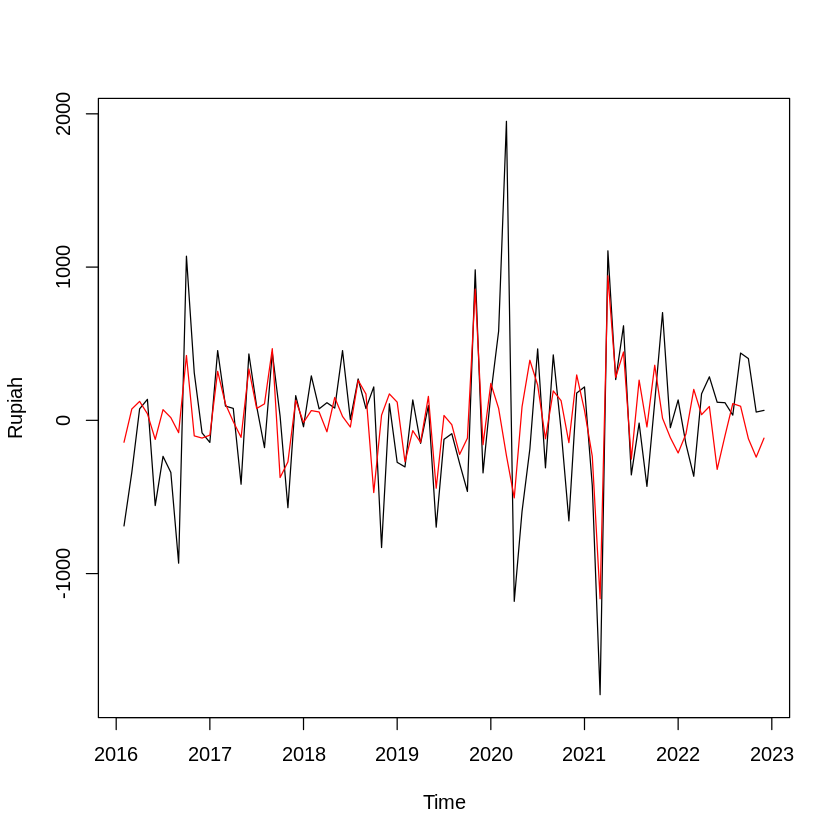

In [15]:
plot(data2)
lines(fitted(model1),col='red')

## Langkah 5 : Uji Diagnosa Model


	Ljung-Box test

data:  Residuals from ARIMA(0,0,1)(2,0,0)[12] with non-zero mean
Q* = 15.497, df = 14, p-value = 0.345

Model df: 3.   Total lags used: 17



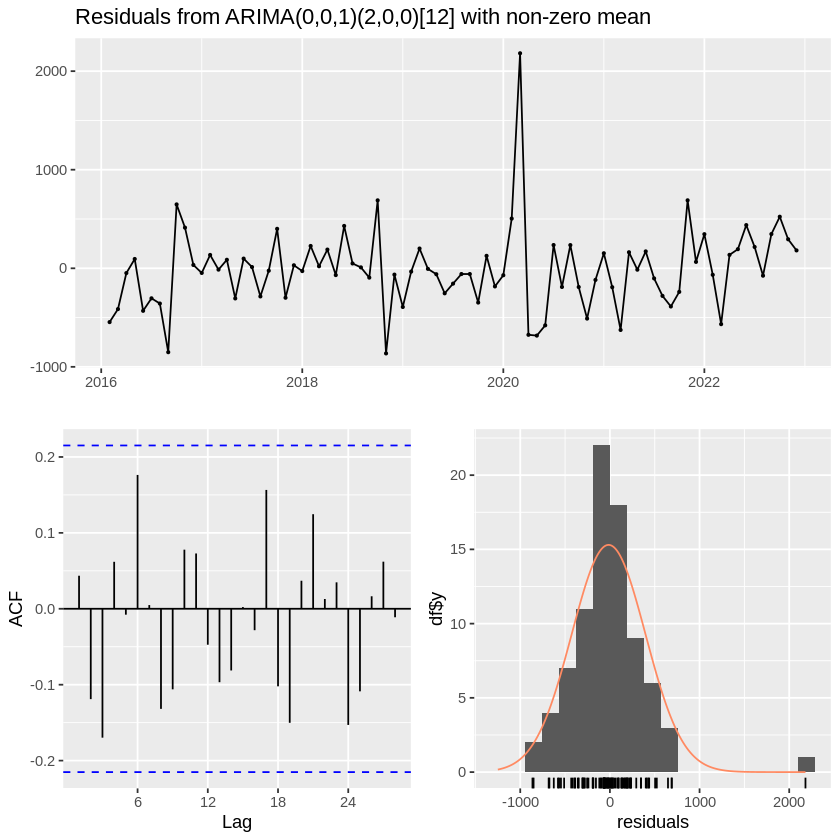

In [16]:
#Plot Residual
checkresiduals(model1,plot=T)

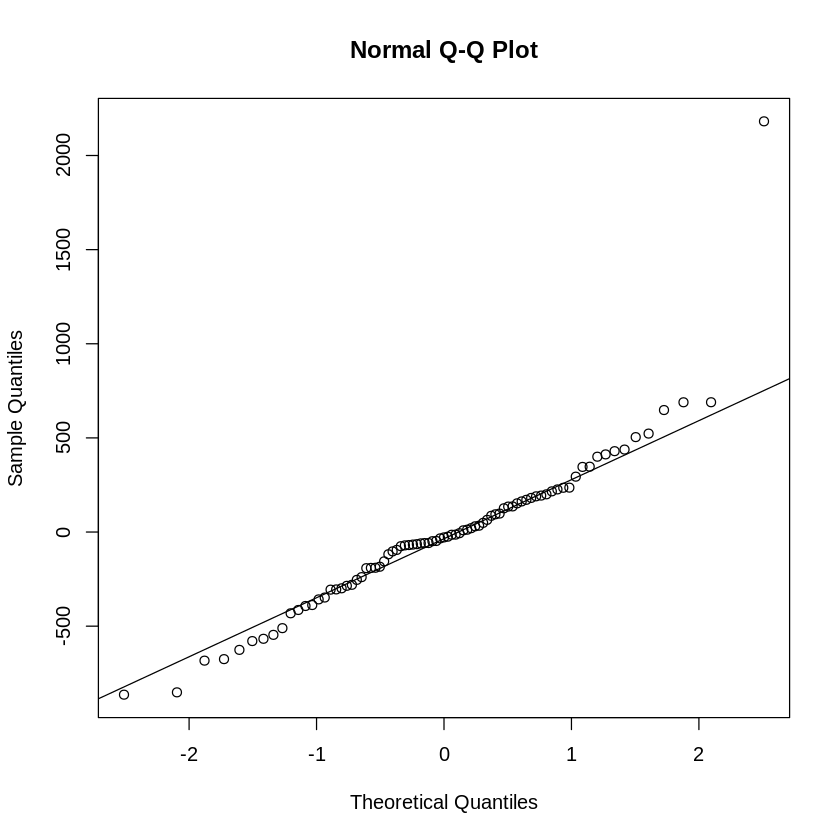

In [17]:
qqnorm(model1$residuals)
qqline(model1$residuals)

In [18]:
jarque.bera.test(model1$residuals)


	Jarque Bera Test

data:  model1$residuals
X-squared = 275.76, df = 2, p-value < 2.2e-16


## Langkah 6 : Uji heteroskedastisitas

> H0 : Tidak terjadi heteroskedastisitas
>
> H1 : Terjadi Heteroskedastisitas


In [22]:
library(FinTS)
for (i in 1:15) {
  ArchTest <- ArchTest(model1$residuals, lags=i, demean=TRUE)
  cat("P Value LM Test lag ke", i,"adalah" , ArchTest$p.value, "\n") }


Attaching package: ‘FinTS’


The following object is masked from ‘package:forecast’:

    Acf




P Value LM Test lag ke 1 adalah 0.3325984 
P Value LM Test lag ke 2 adalah 0.6132599 
P Value LM Test lag ke 3 adalah 0.8086424 
P Value LM Test lag ke 4 adalah 0.8974291 
P Value LM Test lag ke 5 adalah 0.9497787 
P Value LM Test lag ke 6 adalah 0.9722231 
P Value LM Test lag ke 7 adalah 0.9865059 
P Value LM Test lag ke 8 adalah 0.9946019 
P Value LM Test lag ke 9 adalah 0.9974496 
P Value LM Test lag ke 10 adalah 0.9983817 
P Value LM Test lag ke 11 adalah 0.9991134 
P Value LM Test lag ke 12 adalah 0.9996165 
P Value LM Test lag ke 13 adalah 0.9996969 
P Value LM Test lag ke 14 adalah 0.9998651 
P Value LM Test lag ke 15 adalah 0.9999239 


> karena p-value dari lag ke 1-10 $>$ dari 0.05 maka terima ho

In [23]:
library(rugarch)

# Mengumpulkan kesalahan dari model SARIMA
resid <- resid(model1)

# Membuat model GARCH dari residu SARIMA
garch_spec <- ugarchspec(variance.model = list(model = "sGARCH", garchOrder = c(1, 0)),
                         mean.model = list(resid), distribution.model = "std")
garch_model <- ugarchfit(spec = garch_spec, data = data,solver = "hybrid")

# Tampilkan ringkasan model GARCH
print(garch_model)

Warning message in .sgarchfit(spec = spec, data = data, out.sample = out.sample, :
“
ugarchfit-->waring: using less than 100 data
 points for estimation
”



*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: sGARCH(1,0)
Mean Model	: ARFIMA(1,0,1)
Distribution	: std 

Optimal Parameters
------------------------------------
          Estimate  Std. Error  t value Pr(>|t|)
mu      1.7342e+04  2.3298e+03   7.4436 0.000000
ar1     9.9176e-01  1.9500e-03 508.6804 0.000000
ma1    -8.9443e-02  5.4333e-02  -1.6462 0.099722
omega   4.1871e+04  1.3701e+04   3.0560 0.002243
alpha1  8.6788e-01  4.8621e-01   1.7850 0.074262
shape   3.5002e+00  7.9992e-01   4.3757 0.000012

Robust Standard Errors:
          Estimate  Std. Error  t value Pr(>|t|)
mu      1.7342e+04  3.6716e+03   4.7234 0.000002
ar1     9.9176e-01  1.0710e-02  92.5978 0.000000
ma1    -8.9443e-02  5.3519e-02  -1.6712 0.094678
omega   4.1871e+04  1.4185e+04   2.9517 0.003160
alpha1  8.6788e-01  5.9370e-01   1.4618 0.143789
shape   3.5002e+00  6.9701e-01

## Peramalan

In [24]:
# Melakukan prediksi dengan model GARCH
forecast <- ugarchforecast(garch_model, n.ahead = 11)
forecast


*------------------------------------*
*       GARCH Model Forecast         *
*------------------------------------*
Model: sGARCH
Horizon: 11
Roll Steps: 0
Out of Sample: 0

0-roll forecast [T0=Dec 2022]:
     Series Sigma
T+1   15744 204.6
T+2   15758 279.7
T+3   15771 331.3
T+4   15784 370.3
T+5   15796 401.1
T+6   15809 426.0
T+7   15822 446.5
T+8   15834 463.6
T+9   15847 477.9
T+10  15859 490.0
T+11  15871 500.2



### Akurasi

In [27]:
actual_values <- read_excel("rp_usd_2023.xlsx")
actual_values$aktual <- as.numeric(gsub(",", "", actual_values$aktual))

In [28]:
# Mengambil nilai aktual
actual_values <- actual_values$aktual

# Mengambil nilai prediksi dari model GARCH
forecast_values <- as.numeric(forecast@forecast$seriesFor[1,])

# Menghitung MAPE
mape <- mean(abs((actual_values - forecast_values) / actual_values)) * 100

# Menampilkan hasil MAPE
cat("Mean Absolute Percentage Error (MAPE):", mape, "%\n")

Mean Absolute Percentage Error (MAPE): 3.959881 %


## Kesimpulan

Secara keseluruhan, penelitian ini bertujuan untuk memprediksi nilai tukar Rupiah Indonesia (IDR) terhadap Dolar Amerika Serikat (USD) untuk periode Januari 2023 hingga Mei 2023, berdasarkan data dari Januari 2015 hingga Desember 2022. Dengan menggunakan bahasa pemrograman R untuk penelitian yang presisi dan transparan, studi ini menggunakan serangkaian bahan dan alat yang difokuskan, terutama berkaitan dengan kumpulan data utama "Nilai Tukar Rupiah," yang merangkum observasi harian dengan frekuensi harian. Pemilihan bahasa pemrograman R, yang dikenal karena fleksibilitasnya dalam komputasi statistik dan pemodelan deret waktu, memfasilitasi eksplorasi dinamika kompleks nilai tukar Rupiah dan proses pemodelan itu sendiri.

Tahap persiapan data melibatkan prosedur yang menyeluruh, termasuk pengumpulan informasi dari dataset yang disediakan oleh Kementerian Perdagangan Indonesia mengenai nilai tukar IDR ke USD. Pre-processing memastikan kualitas data dengan memeriksa stasioneritas pada rata-rata dan ragam. Uji Augmented Dickey-Fuller mengkonfirmasi stasioneritas setelah differencing, dengan nilai akhir sebesar 0,01, lebih kecil dari tingkat signifikansi (α) 0,05, menunjukkan stasioneritas pada rata-rata.

Proses pemilihan model terbaik menggunakan dua pendekatan, yaitu auto arima dan acf/pacf, yang menghasilkan pilihan model ARIMA(0,0,1)(2,0,0)12. Model ini kemudian digunakan untuk meramalkan nilai tukar IDR ke USD selama 5 bulan ke depan (Januari 2023 - Mei 2023).

Uji diagnostik, termasuk uji Ljung-Box dan analisis residual, memvalidasi model yang dipilih, menunjukkan tidak adanya autokorelasi dan mengkonfirmasi stasioneritas pada residual. Model GARCH selanjutnya, sGARCH(1,0), dipilih berdasarkan tidak adanya heteroskedastisitas dalam model ARIMA.

Hasil ramalan dari model sGARCH(1,0) menunjukkan tren pelemahan yang konsisten dari IDR terhadap USD, dengan penurunan dari 15,745 menjadi 15,801 selama periode 5 bulan. Standar deviasi yang terkait, yang mewakili volatilitas dalam ramalan, menunjukkan pola peningkatan dari 209,9 menjadi 408,9, menunjukkan kisaran ketidakpastian yang semakin melebar dalam ramalan.

Perbandingan dengan data nilai tukar aktual menunjukkan bahwa model sGARCH(1,0) memberikan prediksi yang cukup berbeda dari nilai aktual, dengan Mean Absolute Percentage Error (MAPE) sebesar 3,964986%. Meskipun demikian, MAPE yang relatif rendah menegaskan akurasi tinggi model, menekankan pentingnya mengkaji nilai prediksi individual untuk sepenuhnya memahami keterbatasan model.